In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
from utils import read_metadata_without_fields

In [2]:
providers = sorted(get_dirs(home))
patient_timelines = pd.DataFrame()
cols = ['patient_id', 'treatment_name', 'treatment_type', 'treatment_dose',
       'treatment_starting_date', 'treatment_duration', 'treatment_response', 'response_classification',
       'model_id_treatment', 'sample_id', 'collection_date', 'collection_event',
       'months_since_collection_1', 'age_in_years_at_collection', 'diagnosis',
       'tumour_type', 'primary_site', 'collection_site', 'collection_method', 'treatment_naive_at_collection',
       'treated_at_collection', 'treated_prior_to_collection',
       'response_to_treatment', 'model_id']
for p in providers:
    ps = read_metadata_without_fields(join(home, p, f'{p}_metadata-patient_sample.tsv'))
    if 'treatment' in get_dirs(join(home, p)):
        t = read_metadata_without_fields(join(home, p, 'treatment',f'{p}_patienttreatment-Sheet1.tsv'))
        #merged = t.merge(ps, on='patient_id', how='outer', suffixes=('_treatment', ''))
        t['provider'] = p
        patient_timelines = pd.concat([patient_timelines, t]).reset_index(drop=True)#[cols]

In [3]:
patient_timelines

,patient_id,treatment_name,treatment_type,treatment_dose,treatment_starting_date,treatment_duration,treatment_event,elapsed_time,treatment_response,response_classification,model_id,provider
0,P0001,Gamma-Secretase Inhibitor RO4929097,Targeted therapy,Not provided,Not provided,Not provided,Not provided,Not provided,little/no response,Not provided,ALL-02,CCIA
1,P0001,Ruxolitinib,Immunotherapy,Not provided,Not provided,Not provided,Not provided,Not provided,little/no response,Not provided,ALL-02,CCIA
2,P0001,Glembatumumab Vedotin,Targeted therapy,Not provided,Not provided,Not provided,Not provided,Not provided,little/no response,Not provided,ALL-02,CCIA
3,P0001,PIM Kinase Inhibitor SGI-1776,Targeted therapy,Not provided,Not provided,Not provided,Not provided,Not provided,little/no response,Not provided,ALL-02,CCIA
4,P0001,Cixutumumab,Targeted therapy,Not provided,Not provided,Not provided,Not provided,Not provided,little/no response,Not provided,ALL-02,CCIA
...,...,...,...,...,...,...,...,...,...,...,...,...
6100,UOM_3_71,Tamoxifen,Hormone therapy,Not provided,01/11/2009,5,NaN,NaN,Not provided,Not provided,NaN,UOM-BC
6101,UOM_3_71,Zoledronic Acid,Chemotherapy,Not provided,01/01/2003,Not provided,NaN,NaN,Not provided,Not provided,NaN,UOM-BC
6102,UOM_3_71,Pamidronate Disodium,Chemotherapy,Not provided,01/01/2003,Not provided,NaN,NaN,Not provided,Not provided,NaN,UOM-BC
6103,UOM_3_71,Ibandronic Acid,Chemotherapy,Not provided,01/03/2011,Not provided,NaN,NaN,Not provided,Not provided,NaN,UOM-BC


In [21]:
subset = patient_timelines['treatment_starting_date'].fillna('not provided').str.lower() != 'not provided'
subset = patient_timelines[subset]
subset = subset[subset['treatment_duration'].fillna('not provided').str.lower() != 'not provided']
subset = subset[subset['treatment_duration'].fillna('not provided').str.lower() != 'not collected']
subset = subset[subset['treatment_duration'].fillna('not provided').str.lower() != 'ongoing']
## Removing drugs with + combination as it will require additional logic
subset = subset[~subset['treatment_duration'].fillna('not provided').str.contains('\+')]
subset['treatment_duration'] = [c.replace(' cycles', '').replace(' cycle', '')  if c.__contains__('cycle') else c for c in subset['treatment_duration'] ]
subset['treatment_starting_date'] = pd.to_datetime(subset.treatment_starting_date.str.replace('-', ' 20'), errors='coerce').dt.strftime('%Y-%m-%d')


ps_df = pd.DataFrame()
for provider in subset.provider.unique():
    ps = read_metadata_without_fields(join(home, provider, f'{provider}_metadata-patient_sample.tsv')).fillna('not provided')
    ps = ps[ps['collection_date'] != 'not provided']
    ps_df = pd.concat([ps_df, ps[['model_id', 'sample_id', 'patient_id', 'collection_date']]]).reset_index(drop=True)
ps_df.collection_date = ps_df.collection_date.str.replace('-', ' 20')
ps_df['processed_collection_date'] =  pd.to_datetime(ps_df['collection_date'], errors='coerce', format='%b %Y').dt.strftime('%Y-%m-%d')

/var/folders/_2/g5d3zf4s41g0tvlqkc3_8wjr0000gp/T/ipykernel_91250/3280029897.py:9: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  subset['treatment_starting_date'] = pd.to_datetime(subset.treatment_starting_date.str.replace('-', ' 20'), errors='coerce').dt.strftime('%Y-%m-%d')


In [22]:
ps_df

,model_id,sample_id,patient_id,collection_date,processed_collection_date
0,HBCx-3,1,HBC-3,Mar 2001,2001-03-01
1,HBCx-12A,2,HBC-12,Mar 2003,2003-03-01
2,HBCx-5,3,HBC-5,Dec 2002,2002-12-01
3,HBCx-14,4,HBC-14,Feb 2003,2003-02-01
4,HBCx-17,5,HBC-17,Mar 2006,2006-03-01
...,...,...,...,...,...
255,AB764,AB764_PS,D017121,Aug 2015,2015-08-01
256,CAM2008T3,CAM2008T3_PS,D048008,Apr 2018,2018-04-01
257,PAR1059M,PAR1059M_PS,D014677,Mar 2018,2018-03-01
258,REV085,REV085_PS,D049713,Aug 2018,2018-08-01


In [29]:
# Merge dataframes on the common patient identifier
merged_df = pd.merge(ps_df, subset, on='patient_id', how='right')
merged_df['patient_id'] = merged_df['patient_id'].astype(str)
merged_df = merged_df[~merged_df['collection_date'].isna()]

In [30]:
merged_df[merged_df.collection_date.isna()]

,model_id_x,sample_id,patient_id,collection_date,processed_collection_date,treatment_name,treatment_type,treatment_dose,treatment_starting_date,treatment_duration,treatment_event,elapsed_time,treatment_response,response_classification,model_id_y,provider


In [33]:
treatment_in_days = pd.DataFrame()
for patient_id, patient_data in merged_df.groupby('patient_id'):
    day_0 = pd.to_datetime(min(patient_data['processed_collection_date'].min(), patient_data['treatment_starting_date'].min()), errors='coerce')
    patient_data['processed_collection_date'] = pd.to_datetime(patient_data['processed_collection_date'], errors='coerce')
    #print(f"Day 0: {day_0} and collection date: {patient_data['processed_collection_date']}")
    # Plot collection date
    collection_days = (patient_data['processed_collection_date'] - day_0).dt.days
    patient_data['collection_date_days'] = collection_days
    patient_data['treatment_duration_days'] = 0
    patient_data['treatment_start_date_days'] = 0
    for _, row in patient_data.iterrows():
        tsd = pd.to_datetime(row['treatment_starting_date'], errors='coerce')
        treatment_start = (tsd - day_0).days
        duration = row['treatment_duration'].split()[0]
        duration = int(duration) * 30 if duration.isdigit() else 30  # Assume 1 cycle ≈ 30 days
        row['treatment_start_date_days'] = treatment_start
        row['treatment_duration_days'] = duration
        treatment_in_days = pd.concat([treatment_in_days, row], axis=1)

In [35]:
treatment_in_days.transpose()

,model_id_x,sample_id,patient_id,collection_date,processed_collection_date,treatment_name,treatment_type,treatment_dose,treatment_starting_date,treatment_duration,treatment_event,elapsed_time,treatment_response,response_classification,model_id_y,provider,collection_date_days,treatment_duration_days,treatment_start_date_days
261,AB582C,AB582C_PS,D014655,Feb 2014,2014-02-01,Pertuzumab/Trastuzumab/Docetaxel Followed by F...,Chemotherapy,Not provided,2014-02-17,4,NaN,NaN,Not provided,Not provided,AB582C,UOC-BC,0,120,16
262,AB582P,AB582P_PS,D014655,Feb 2014,2014-02-01,Pertuzumab/Trastuzumab/Docetaxel Followed by F...,Chemotherapy,Not provided,2014-02-17,4,NaN,NaN,Not provided,Not provided,AB582C,UOC-BC,0,120,16
263,AB582C,AB582C_PS,D014655,Feb 2014,2014-02-01,Radiation Therapy,Radiation therapy,Not provided,2014-10-07,1,NaN,NaN,Not provided,Not provided,AB582C,UOC-BC,0,30,248
264,AB582P,AB582P_PS,D014655,Feb 2014,2014-02-01,Radiation Therapy,Radiation therapy,Not provided,2014-10-07,1,NaN,NaN,Not provided,Not provided,AB582C,UOC-BC,0,30,248
265,AB582C,AB582C_PS,D014655,Feb 2014,2014-02-01,Paclitaxel,Chemotherapy,Not provided,2017-06-02,3,NaN,NaN,Not provided,Not provided,AB582C,UOC-BC,0,90,1217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,PAC0013PR,PAC0013PRH0000000000VT9900,PTX-PAC-006,Jun 2013,2013-06-01,Vincristine+Chlorambucil+Procarbazine+Prednisone,Chemotherapy+Chemotherapy+Chemotherapy+Immunot...,"Vincristine 1,4 mg/m2 on day 1 and 8, chloramb...",2008-05-01,4,NaN,NaN,complete response,RECIST 1.1,NaN,TRACE,2223,120,366
140,PAC0005PR,PAC0005PRH0000000000VT9900,PTX-PAC-007,Jul 2013,2013-07-01,Radiation Therapy,Radiation therapy,66 Gy in 33 fractions of 2 Gy each,2013-04-01,2.5,NaN,NaN,Not provided,Not provided,NaN,TRACE,91,30,0
141,PAC0005PR,PAC0005PRH0000000000VT9900,PTX-PAC-007,Jul 2013,2013-07-01,Gemcitabine,Chemotherapy,Gemcitabine 1000 mg/m2 weekly (7 of 8 wks in c...,2013-07-01,2,NaN,NaN,progressive disease,RECIST 1.1,NaN,TRACE,91,60,91
142,PAC0012PR,PAC0012PRH0000000000VT9900,PTX-PAC-010,Sep 2013,2013-09-01,Gemcitabine,Chemotherapy,Gemcitabine 1000 mg/m2 weekly (7 of 8 wks in c...,2013-09-01,2,NaN,NaN,progressive disease,RECIST 1.1,NaN,TRACE,0,60,0


In [9]:
collection_days

261    0
262    0
263    0
264    0
265    0
266    0
267    0
268    0
269    0
270    0
271    0
272    0
Name: processed_collection_date, dtype: int64

TypeError: '<' not supported between instances of 'str' and 'float'

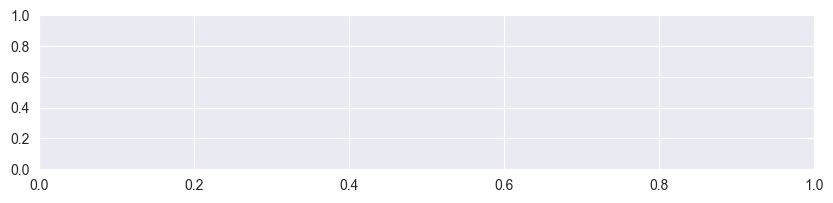

In [14]:

# Initialize a plot for each patient timeline
for patient_id, patient_data in merged_df.groupby('patient_id'):
    fig, ax = plt.subplots(figsize=(10, 2))
    #print(f'Patient ID: {patient_id}')
    # Determine day 0 as the earliest date for each patient
    day_0 = pd.to_datetime(min(patient_data['processed_collection_date'].min(), patient_data['treatment_starting_date'].min()), errors='coerce')
    patient_data['processed_collection_date'] = pd.to_datetime(patient_data['processed_collection_date'], errors='coerce')
    #print(f"Day 0: {day_0} and collection date: {patient_data['processed_collection_date']}")
    # Plot collection date
    collection_days = (patient_data['processed_collection_date'] - day_0).dt.days
    ax.plot(collection_days, [1] * len(collection_days), 'bo', label='Collection Date')
    ax.text(collection_days.to_list()[0]-5, 1.001, 'Sample collection', rotation=90, ha='right', fontsize=8)
    # Plot treatments with duration on the timeline
    for _, row in patient_data.iterrows():
        tsd = pd.to_datetime(row['treatment_starting_date'], errors='coerce')
        treatment_start = (tsd - day_0).days
        duration = row['treatment_duration'].split()[0]
        duration = int(duration) * 30 if duration.isdigit() else 30  # Assume 1 cycle ≈ 30 days
        #print(row)
        #print([treatment_start, treatment_start + duration])
        ax.plot([treatment_start, treatment_start + duration], [1,1], 'r-', label='Treatment Duration')
        ax.text(treatment_start+10, 1.001, row['treatment_name'], rotation=90, ha='right', fontsize=8)
    
    # Formatting the plot
    ax.set_yticks([])
    ax.set_xlabel("Days from First Event")
    ax.set_title(f"Patient Timeline for {patient_id}")
    #ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #plt.tight_layout()
    plt.savefig(f'patient_timeline_plot/{str(patient_id)}_patient_timeline.png', format='png', dpi=600, bbox_inches='tight')
    plt.close()

In [17]:
len(merged_df.patient_id.unique())

68

In [21]:
merged_df

,model_id_x,sample_id,patient_id,collection_date,processed_collection_date,treatment_name,treatment_type,treatment_dose,treatment_starting_date,treatment_duration,treatment_event,elapsed_time,treatment_response,response_classification,model_id_y,provider
0,HBCx-31,BC297,HBCx-31,Oct 2007,2007-10-01,FEC Regimen+Docetaxel,Chemotherapy+Immunotherapy,FEC100+Not provided,2007-11-01,3,Not collected,Not collected,No relapse,Not collected,HBCx-31,Curie-BC
1,HBCx-31,BC297,HBCx-31,Oct 2007,2007-10-01,Radiation Therapy,Radiation therapy,Not provided,2008-04-01,1,Not collected,Not collected,No relapse,Not collected,HBCx-31,Curie-BC
2,HBCx-39,BC408,HBCx-39,Feb 2009,2009-02-01,3FUN,Not provided,Not provided,2009-04-01,2,Not collected,Not collected,Progressive disease,Not collected,HBCx-39,Curie-BC
3,HBCo-39,BC408-PDXO,HBCx-39,Feb 2009,2009-02-01,3FUN,Not provided,Not provided,2009-04-01,2,Not collected,Not collected,Progressive disease,Not collected,HBCx-39,Curie-BC
4,HBCx-39,BC408,HBCx-39,Feb 2009,2009-02-01,Radiation Therapy,Radiation therapy,Not provided,2009-04-01,1,Not collected,Not collected,Progressive disease,Not collected,HBCx-39,Curie-BC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,NaN,NaN,UOM_3_71,NaN,NaN,Anastrozole,Hormone therapy,Not provided,2004-01-08,29,NaN,NaN,Not provided,Not provided,NaN,UOM-BC
363,NaN,NaN,UOM_3_71,NaN,NaN,Fulvestrant,Hormone therapy,Not provided,2007-01-03,6,NaN,NaN,Not provided,Not provided,NaN,UOM-BC
364,NaN,NaN,UOM_3_71,NaN,NaN,Exemestane,Hormone therapy,Not provided,2008-01-03,13,NaN,NaN,Not provided,Not provided,NaN,UOM-BC
365,NaN,NaN,UOM_3_71,NaN,NaN,Tamoxifen,Hormone therapy,Not provided,2009-01-11,5,NaN,NaN,Not provided,Not provided,NaN,UOM-BC


In [8]:
patient_id

'D014655'

array(['Curie-BC', 'IRCCS-GC', 'LIH', 'TRACE', 'UOC-BC', 'UOM-BC'],
      dtype=object)

In [24]:
subset.treatment_duration.unique()

array(['3', '1', '2', '6', '55', '4', '5', '44', '59', '24', '53', '7',
       '19', '10', '18', '33', '0.5', '2.5', '8', '14', '1.5', '3.5',
       '66', '21', '20', '15', '12', '9', '40', '22', '13', '48', '23',
       '50', '60', '25', '29'], dtype=object)

In [9]:
subset.treatment_starting_date.unique()

array(['Mar-01', 'Jan-03', 'Oct-07', 'Nov-07', 'Apr-08', 'Sep-08',
       'Feb-09', 'Apr-09', 'May-14', 'Aug-14', 'Sep-14', 'Feb-15',
       'Mar-15', 'Dec-07', 'Jul-08', 'Sep-15', 'Feb-16', 'Mar-16',
       'May-16', 'Jun-16', 'Jan-06', 'Aug-06', 'Oct-06', 'Jan-07',
       'May-08', 'Jul-16', 'Aug-16', 'Jun-15', 'Oct-15', 'Sep-16',
       'Apr-16', 'Mar-96', 'Mar-98', 'May-01', 'Jan-05', 'Aug-05',
       'Feb-11', 'Nov-12', 'Jul-13', 'Oct-16', 'Jan-01', 'Dec-01',
       'Apr-02', 'Jul-03', 'Dec-14', 'May-15', 'Nov-16', 'Feb-17',
       'Jan-15', 'Jul-15', 'Jan-16', 'Dec-16', 'Feb-04', 'Jan-18',
       'Mar-18', 'Jun-03', 'Aug-08', 'Oct-17', 'Nov-17', 'Sep-18',
       'Aug-18', 'Oct-18', 'Apr-19', 'May-19', 'Aug-15', 'Nov-15',
       'Jul-19', 'Jan-20', 'Aug-19', 'Feb-20', 'Oct-20', 'Apr-18',
       'Feb-19', 'Nov-19', 'Aug-20', 'Dec-20', 'Mar-17', 'Sep-19',
       'Jun-21', 'Dec-21', 'Mar-21', 'Aug-21', 'Nov-21', 'Jan-22',
       'Jun-22', 'Aug-22', 'Oct-22', 'Jun-14', 'Jan-11', 'Sep-

In [8]:
patient_timelines['treatment_schedule'].str.lower().unique()

KeyError: 'treatment_schedule'

In [56]:
patient_timelines[patient_timelines['response_classification'] == 'TGI (tumor growth inhibition)'].provider.unique()

array(['Curie-LC'], dtype=object)

In [54]:
patient_timelines['response_classification'].unique()

array(['RECIST 1.1', 'TGI (tumor growth inhibition)', 'not provided',
       'Not provided'], dtype=object)

In [55]:
patient_timelines['treatment_response'].str.lower().unique()

array(['progressive disease', 'stable disease', 'not provided',
       'partial response', 'complete response'], dtype=object)

In [40]:
patient_timelines['response_classification'].unique()

array(['Not provided', 'Not collected', 'MD Anderson', 'RECIST 1.1'],
      dtype=object)

In [42]:
patient_timelines['treatment_response'].str.lower().unique()

array(['little/no response', 'progressive disease', 'partial response',
       'stable disease', 'not provided', 'good response', 'no relapse',
       'neoadjuvant treatement : rcb class ii ',
       'neoadjuvant treatement : rcb class iii ',
       'neoadjuvant treatement : rcb class i ', 'complete response',
       'no response', 'residual disease'], dtype=object)

In [3]:
pt_with_date = patient_timelines[patient_timelines['treatment_starting_date'].fillna('Not provided')!='Not provided']
len(pt_with_date['model_id'].unique())

184

In [4]:
pt_with_date

,patient_id,treatment_name,treatment_type,treatment_dose,treatment_starting_date,treatment_duration,treatment_response,response_classification,model_id_treatment,sample_id,...,diagnosis,tumour_type,primary_site,collection_site,collection_method,treatment_naive_at_collection,treated_at_collection,treated_prior_to_collection,response_to_treatment,model_id
1927,HBCx-2,Mastectomy+Lymphadenectomy,Surgery,Not provided,Mar-01,Not collected,Progressive disease,Not collected,HBCx-2,BC51,...,breast carcinoma,metastatic,breast,lymph node,Not provided,yes,no,no,Not provided,HBCx-2
1928,HBCx-8,Mastectomy+Lymphadenectomy,Surgery,Not provided,Jan-03,Not collected,Progressive disease,Not collected,HBCx-8,BC138,...,breast carcinoma,primary,breast,breast,Not provided,yes,no,no,Not provided,HBCx-8
1929,HBCx-8,Mastectomy+Lymphadenectomy,Surgery,Not provided,Jan-03,Not collected,Progressive disease,Not collected,HBCx-8,BC138-PDXO,...,breast carcinoma,primary,breast,breast,Not provided,yes,no,no,Not provided,HBCo-8
1930,HBCx-30,Mastectomy+Lymphadenectomy,Surgery,Not provided,Oct-07,Not collected,Progressive disease,Not collected,HBCx-30,BC291,...,breast carcinoma,primary,breast,breast,Not provided,yes,no,no,Not provided,HBCx-30
1931,HBCx-31,Mastectomy+Lymphadenectomy,Surgery,Not provided,Oct-07,Not collected,No relapse,Not collected,HBCx-31,BC297,...,breast carcinoma,primary,breast,breast,Not provided,yes,no,no,Not provided,HBCx-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11313,UOM_3_71,Tamoxifen,Hormone therapy,Not provided,01/11/2009,5,Not provided,Not provided,NaN,3_71,...,intraductal breast neoplasm,metastatic,Breast,Pleural Effusion,Not provided,no,yes,YES,Not provided,BB3RC71
11314,UOM_3_71,Zoledronic Acid,Chemotherapy,Not provided,01/01/2003,Not provided,Not provided,Not provided,NaN,3_71,...,intraductal breast neoplasm,metastatic,Breast,Pleural Effusion,Not provided,no,yes,YES,Not provided,BB3RC71
11315,UOM_3_71,Pamidronate Disodium,Chemotherapy,Not provided,01/01/2003,Not provided,Not provided,Not provided,NaN,3_71,...,intraductal breast neoplasm,metastatic,Breast,Pleural Effusion,Not provided,no,yes,YES,Not provided,BB3RC71
11316,UOM_3_71,Ibandronic Acid,Chemotherapy,Not provided,01/03/2011,Not provided,Not provided,Not provided,NaN,3_71,...,intraductal breast neoplasm,metastatic,Breast,Pleural Effusion,Not provided,no,yes,YES,Not provided,BB3RC71
